In [1]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(1337) # Repetibilidad

# Ejercicio 1

### (a) 

En el ejercicio 5 de la guía se ve que, si $X$ es una variable aleatoria uniformemente distribuida en el intervalo $[-\frac{\pi}{2}, \frac{\pi}{2}]$ y $g: [-\frac{\pi}{2}, \frac{\pi}{2}] \to \mathbb{R}$ está dada por $g(x) = x_0 + \gamma * tan(x)$, entonces la variable aleatoria $Y=g(X)$ está distribuida según la distribución de Cauchy con parámetros $x_0$ (mediana) y $\gamma$ (escala). Es decir que teniendo una variable aleatoria uniformemente distribuida en $[-\frac{\pi}{2}, \frac{\pi}{2}]$ podemos construir fácilmente números que sigan la distribución de Cauchy con parámetros $x_0$ y $\gamma$: simplemente tomamos generamos números $x$ distribuidos según $X$ y consideramos $g(x)$.

En este caso tenemos a nuestra disposición $U \mathtt{\sim} Unif(0, 1)$, pero es un detalle menor que se arregla fácilmente: podemos obtener una variable aleatoria idénticamente distribuida a $X$ a partir de $U$ haciendo $h(U)$, donde $h(u) = -\frac{\pi}{2} + u\pi$. En efecto:

$$F_{h(U)}(x) = P(h(U) \leq x) = P(U \leq \frac{x + \frac{\pi}{2}}{\pi}) = F_U(\frac{x + \frac{\pi}{2}}{\pi})$$ 

$$F_{h(U)}(x) =  F_U(\frac{x + \frac{\pi}{2}}{\pi}) = \begin{cases}
       0 &\quad\frac{x + \frac{\pi}{2}}{\pi} \le  0\\
       \frac{x + \frac{\pi}{2}}{\pi} &\quad 0 < \frac{x + \frac{\pi}{2}}{\pi} \le 1 \\
       1 &\quad \frac{x + \frac{\pi}{2}}{\pi} > 1\\
     \end{cases} = \begin{cases}
       0 &\quad x \le  -\frac{\pi}{2}\\
       \frac{x + \frac{\pi}{2}}{\pi} &\quad -\frac{\pi}{2} < x \le \frac{\pi}{2} \\
       1 &\quad x > \frac{\pi}{2}\\
     \end{cases}$$

Luego, para obtener sampleos distribuidos como Cauchy con parámetros $x_0$ y $\gamma$ a partir de $U$, simplemente debemos hacer $g(h(U))$

In [2]:
# Funciones h y g

def h(u):
    """Mapea Unif(0, 1) en Unif(-pi/2, pi/2)"""
    return - np.pi * 0.5 + np.pi * u

def g(x, x0=0, gamma=1): 
    """Mapea Unif(-pi/2, pi/2) en Cauchy(x0, gamma)"""
    return x0 + gamma * np.tan(x)

In [3]:
# Sampleo

n_muestras = 10000
x0 = 0 # modificar a gusto
gamma = 1 # modificar a gusto

muestras_uni = np.random.rand(n_muestras)
muestras_x = h(muestras_uni)
muestras_cauchy = g(muestras_x, x0, gamma)


Para graficar la distribución de Cauchy hay que hacer una elección arbitraria: el rango $[a, b]$ en el cual concentrarnos. Si bien sampleando números como acabamos de hacer podemos haber obtenido como resultado números arbitrariamente grandes o chicos, si mostramos todo el rango de valores sampleados no obtendremos algo muy diferente a algo que parezca una delta de Dirac. Por razones que tienen que ver con el inciso (b) del problema, elegimos:
$$ c = tan(-0.475\pi) \approx -12.7 $$
$$ a = x_0 + c * \gamma$$
$$ b = x_0 - c * \gamma$$

In [4]:
# Límites del intervalo a considerar

c = np.tan(-0.475 * np.pi)
a = x0 + c * gamma
b = x0 - c * gamma

In [5]:
# Distribución de Cauchy

def cauchy(x, x0=0, gamma=1):
    """Distribucion de Cauchy(x0, gamma)"""
    ret = x - x0
    ret = ret / gamma
    ret = ret ** 2
    ret = 1 + ret
    ret = np.pi * gamma * ret
    ret = 1 / ret
    return ret

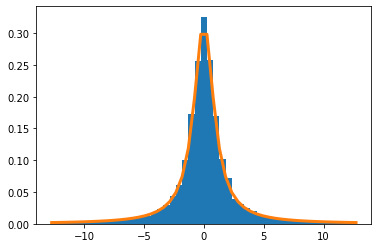

In [6]:
# Histograma con valor teórico superpuesto

cauchy_x = np.linspace(a, b)
cauchy_y = cauchy(cauchy_x)

plt.hist(muestras_cauchy, bins=cauchy_x, density=True)
plt.plot(cauchy_x, cauchy_y, linewidth=3)
plt.show()

### (b)

Hora de explicar el por qué de la elección de ese rango en particular. En esta sección se hará uso de un método Monte Carlo para simular una distribución de Cauchy. El método, sin embargo, precisa que la distribución simulada se encuentre acotada en un cierto intervalo. Como la distribución de Cauchy está definida en toda la recta, hace falta hacer un recorte razonable. Por consistencia, hacemos el mismo a lo largo de todo el trabajo.

Al no estar definido el valor medio ni la varianza de la distribución, no resulta posible elegir un rango del estilo (valor medio $\pm$ n desviaciones estándar). Lo que sí podemos hacer, considerando la simetría de la distribución con respecto a la mediana, es usar la función de distribución acumulada para encontrar una "cola" de la distribución que represente una cierta probabilidad que estemos dispuestos a despreciar. Por lo tanto, si elegimos como rango (mediana $\pm$ la distancia de la mediana a ese valor) estaremos despreciando dos veces la probabilidad de la "cola". En concreto: la función de distribución acumulada de Cauchy es:

$$F(x) = \frac{1}{2} + \frac{1}{\pi}arctan(\frac{x - x_0}{\gamma})$$

El corte que consideramos es 5%: simularemos el 95% de la distribución a ambos lados de la mediana. Para ello, la condición resulta:

$$ F(x) = 0.025 $$

Y por lo tanto 

$$ x = x_0 + \gamma * tan((0.025 - 0.5)\pi) $$

La distancia entre la mediana y este valor es:

$$ x_0 - x = -\gamma * tan((0.025 - 0.5)\pi) $$

Y por lo tanto consideramos el intervalo ($x_0 \pm -\gamma * tan((0.025 - 0.5)\pi)$)

Con esta información, implementamos el algoritmo de aceptación-rechazo. Pero primero, una aclaración. Como vamos a trabajar con una distribución de probabilidad restringida a un subdominio, la misma no estará normalizada. Una pregunta válida es cuestionar si es necesario que la función que se usa para obtener los datos con el algoritmo sea una distribución de probabilidad para ese intervalo, es decir si es necesario que esté normalizada. La respuesta es que no (razón por la cual no hará falta reescalar la distribución de Cauchy). La razón es simple: consideremos a $f$ la distribución de Cauchy(0, 1) usual y $f_r$ la misma distribución renormalizada para que al integrarse en el intervalo de interés de 1. Naturalmente, $f_r = M * f$, con $M > 1$. En este caso en particular, $M = \frac{1}{0.95}$, pero mejor dejarlo genérico para que sea más claro. El criterio de aceptación de un número aleatorio usando el algoritmo de aceptación-rechazo es:

$$ f_m*z < f(u) $$

Con $u$ distribuido uniformemente en el intervalo de interés y $z$ distribuido uniformemente entre 0 y 1. Esto asegura que las proporciones relativas entre los distintos valores respeta los determinados por la densidad de probabilidad. Esto se nota cualitativamente considerando el caso discreto: si $P(x_i) = 2 * P(x_j)$, se espera que la proporción de sucesos $x_i$ sea el doble que la de $x_j$. Esto es exactamente lo que garantiza el algoritmo: la condición $A * z < P(x_i)$ se va a satisfacer estadísticamente el doble de veces que $A * z < P(x_j)$, para cualquier $A$.

Como, claramente, $ f_{m_r} = M * f_m $, la condición es equivalente usando las funciones normalizada y sin normalizar:

$$ f_m*z < f(u) \iff M * f_m*z < M * f(u) \iff f_{m_r}*z < f_r(u)$$


In [7]:
# Aceptación-rechazo

def aceptacion_rechazo(a, b, f, f_max):
    """Algoritmo de aceptación-rechazo"""
    y = np.random.rand()
    z = np.random.rand()
    
    u = a + (b-a) * y
    if z * f_max < f(u):
        return u
    

In [8]:
# 10000 muestras

a = x0 + gamma * np.tan(-0.475 * np.pi)
b = x0 - gamma * np.tan(-0.475 * np.pi)
f = cauchy
f_max = f(x0)

muestras_mc = np.empty(1)

while muestras_mc.size < n_muestras:
    muestra = aceptacion_rechazo(a, b, f, f_max)
    if muestra:
        muestras_mc = np.append(muestras_mc, muestra)

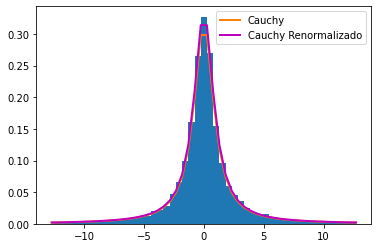

In [9]:
# Histograma con valores teóricos superpuestos

plt.hist(muestras_mc, bins=cauchy_x, density=True)
plt.plot(cauchy_x, cauchy_y, linewidth=2, label="Cauchy")
plt.plot(cauchy_x, cauchy_y / 0.95, linewidth=2, color='m', label="Cauchy Renormalizado")
plt.legend()
plt.show()

Un comentario: la comparación fidedigna con la curva de Cauchy es es con la reescaleada, que es el resultado de normalizar el resultado del algoritmo de Monte Carlo. En efecto, en el rango considerado la suma del histograma da 1 pero la distribución de Cauchy normal 0.95. Por eso, para comparar fidedignamente la forma funcional de la distribución que queremos simular con los datos generados hay que usar la versión renormalizada.

# Ejercicio 2

### Funciones de variables aleatorias

Si $X$ es una variable aleatoria y $g: \mathbb{R} \to \mathbb{R}$, $Y = g(X)$ es una nueva variable aleatoria. Si $g$ es monótona e invertible, ocurre que

$$F_Y(x) = \begin{cases}
       F_X(h(x)) & h = g^{-1}  creciente\\
       1 - F_X(h(x)) & h = g^{-1} decreciente\\
     \end{cases}$$
     
En nuestro caso,

$$F_X = \begin{cases}
       0 &\quad x \le  0\\
       x &\quad 0 < x \le 1 \\
       1 &\quad x > 1\\
     \end{cases}$$
     
Y queremos

$$ F_Y = \begin{cases}
       0 &\quad y \le  0\\
       1 - e^{-\lambda y} &\quad y > 0 \\
     \end{cases}$$

Por lo que tenemos que encontrar una cierta $g: [0, 1] \to [0, \infty)$ monótona, creciente o decreciente, y bien comportada. Teniendo en cuenta la relación que va a vincular ambas funciones de densidad acumuladas, la forma funcional de $F_Y$ resulta bastante sugestiva. Veamos que es directo encontrar una $g$ decreciente, considerando $h = g^{-1}$.

$$F_Y(y) = 1 - F_X(h(y)) = 1 - e^{-\lambda y}$$
$$F_X(h(y)) = e^{-\lambda y}$$

Como $h: [0, \infty) \to [0, 1]$, $0< h(y) < 1$, y por lo tanto $F_X(h(y)) = h(y)$. Eso es compatible con que $e^{-\lambda y}$ esté entre $0$ y $1$. Luego,

$$h(y) = e^{-\lambda y}$$

$$g(x) = -\frac{\ln x}{\lambda}$$

In [10]:
# g

def g(x, lam=1):
    """Mapea Unif(0, 1) en Exp(lam)"""
    return -np.log(x)/lam

In [11]:
# Sampleo

n_muestras = 500
lam = 0.25

muestras_uni = np.random.rand(n_muestras)
muestras_exp = g(muestras_uni, lam)

Como antes, tenemos que elegir un rango para graficar los datos generados. Para mantener la consistencia, representaremos el 95% de la curva. Si $Y \mathtt{\sim}Exp(\lambda)$,

$$F_Y(y) = 1 - e^{-\lambda y}$$

Por lo que si queremos el 95% de la curva (esta vez buscamos la cola posterior, siendo que la distribución de probabilidad es exponencialmente decreciente):

$$F_X(y) = 0.95 = 1 - e^{-\lambda y}$$
$$e^{-\lambda y} = 0.05$$
$$ y = -\frac{\ln 0.05}{\lambda} \approx 12 $$ 

Esto es un inconveniente, porque en el inciso se pide representar lo que ocurre para $Y \ge 15$. Por esa única razón, consideraremos el intervalo $[0, 30]$

In [12]:
# Límites del intervalo a considerar
a = 0
b = 30

In [13]:
# Distribución exponencial

def exponencial(y, lam=1):
    """Densidad de probabilidad exponencial con parámetro lam"""
    return lam * np.exp(-lam * y)

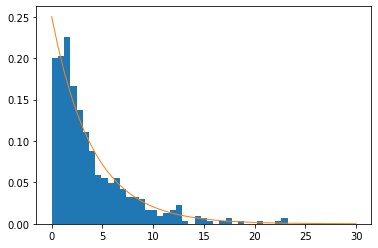

In [14]:
# Histograma regular con valor teórico superpuesto

exp_x = np.linspace(a, b)
exp_y = exponencial(exp_x, lam)

plt.hist(muestras_exp, bins=exp_x, density=True)
plt.plot(exp_x, exp_y, linewidth=1)
plt.show()

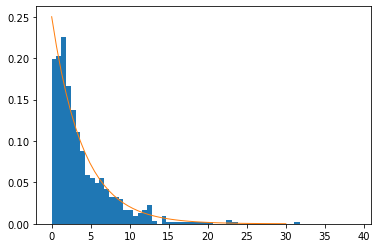

In [15]:
# Histograma con bins variables y valor teórico superpuesto

bins_var = np.copy(exp_x)
bins_var[bins_var >= 15] *= 1.3

plt.hist(muestras_exp, bins=bins_var, density=True)
plt.plot(exp_x, exp_y, linewidth=1)
plt.show()

Para que coincida la altura de los bines con la distribución, los mismos deberían tener una altura igual a la integral de la distribución de probabilidad en el rango que los compete. Esto naturalmente irá ocurriendo al tomar una cantidad mayor de muestras. Por ejemplo, con 10000 muestras como en el ejercicio anterior:

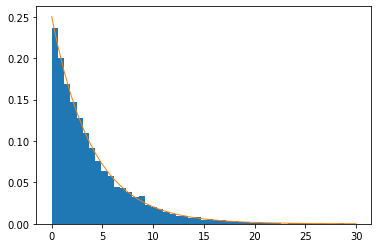

In [16]:
n_muestras = 10000
lam = 0.25

muestras_uni = np.random.rand(n_muestras)
muestras_exp = g(muestras_uni, lam)

plt.hist(muestras_exp, bins=exp_x, density=True)
plt.plot(exp_x, exp_y, linewidth=1)
plt.show()